# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
from collections import deque
from ddpg_agent_multi_2 import Agents
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", worker_id=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [6]:
agent = Agents(state_size=state_size, action_size=action_size,
               num_agents = num_agents, random_seed=0)

In [7]:
def ddpg(n_episodes=3000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            #rewards = [np.max(env_info.rewards) for _ in env_info.rewards]
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                print('\tSteps: ', t)
                break 
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.format(i_episode, np.mean(scores_deque), np.max(score)), end="")
        if i_episode % 500 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')   
    return scores

scores = ddpg()

	Steps:  14
Episode 1	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 2	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 3	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 4	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 5	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 6	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 7	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 8	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 9	Average Score: 0.00	Score: 0.000	Steps:  29
Episode 10	Average Score: 0.01	Score: 0.090	Steps:  13
Episode 11	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 12	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 13	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 14	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 15	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 16	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 17	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 18	Average Score: 0.01	Score: 0.000	Steps:  13
Episode

Episode 149	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 150	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 151	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 152	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 153	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 154	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 155	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 156	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 157	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 158	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 159	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 160	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 161	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 162	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 163	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 164	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 165	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 166	Average Score: 0.00	Score: 0.000	Ste

Episode 295	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 296	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 297	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 298	Average Score: 0.00	Score: 0.000	Steps:  15
Episode 299	Average Score: 0.00	Score: 0.000	Steps:  15
Episode 300	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 301	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 302	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 303	Average Score: 0.00	Score: 0.000	Steps:  16
Episode 304	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 305	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 306	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 307	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 308	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 309	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 310	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 311	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 312	Average Score: 0.00	Score: 0.000	Ste

Episode 442	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 443	Average Score: 0.00	Score: 0.000	Steps:  32
Episode 444	Average Score: 0.00	Score: 0.100	Steps:  14
Episode 445	Average Score: 0.00	Score: 0.000	Steps:  29
Episode 446	Average Score: 0.01	Score: 0.100	Steps:  30
Episode 447	Average Score: 0.01	Score: 0.090	Steps:  13
Episode 448	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 449	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 450	Average Score: 0.01	Score: 0.000	Steps:  29
Episode 451	Average Score: 0.01	Score: 0.090	Steps:  14
Episode 452	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 453	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 454	Average Score: 0.01	Score: 0.000	Steps:  18
Episode 455	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 456	Average Score: 0.01	Score: 0.000	Steps:  16
Episode 457	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 458	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 459	Average Score: 0.01	Score: 0.000	Ste

Episode 588	Average Score: 0.01	Score: 0.000	Steps:  16
Episode 589	Average Score: 0.01	Score: 0.000	Steps:  15
Episode 590	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 591	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 592	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 593	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 594	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 595	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 596	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 597	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 598	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 599	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 600	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 601	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 602	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 603	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 604	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 605	Average Score: 0.00	Score: 0.000	Ste

Episode 734	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 735	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 736	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 737	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 738	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 739	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 740	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 741	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 742	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 743	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 744	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 745	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 746	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 747	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 748	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 749	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 750	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 751	Average Score: 0.00	Score: 0.000	Ste

Episode 880	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 881	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 882	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 883	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 884	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 885	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 886	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 887	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 888	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 889	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 890	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 891	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 892	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 893	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 894	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 895	Average Score: 0.00	Score: 0.000	Steps:  14
Episode 896	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 897	Average Score: 0.00	Score: 0.000	Ste

Episode 1026	Average Score: 0.01	Score: 0.000	Steps:  44
Episode 1027	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 1028	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1029	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1030	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1031	Average Score: 0.01	Score: 0.000	Steps:  30
Episode 1032	Average Score: 0.01	Score: 0.100	Steps:  14
Episode 1033	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1034	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1035	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1036	Average Score: 0.01	Score: 0.000	Steps:  12
Episode 1037	Average Score: 0.01	Score: 0.000	Steps:  45
Episode 1038	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 1039	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1040	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1041	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1042	Average Score: 0.01	Score: 0.000	Steps:  32
Episode 1043	Average Score: 0.0

Episode 1169	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1170	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1171	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1172	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1173	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1174	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1175	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1176	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1177	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 1178	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1179	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1180	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1181	Average Score: 0.01	Score: 0.000	Steps:  34
Episode 1182	Average Score: 0.01	Score: 0.090	Steps:  13
Episode 1183	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1184	Average Score: 0.01	Score: 0.000	Steps:  32
Episode 1185	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 1186	Average Score: 0.0

Episode 1312	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1313	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1314	Average Score: 0.02	Score: 0.000	Steps:  30
Episode 1315	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 1316	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1317	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1318	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1319	Average Score: 0.02	Score: 0.000	Steps:  19
Episode 1320	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1321	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1322	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1323	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 1324	Average Score: 0.02	Score: 0.090	Steps:  13
Episode 1325	Average Score: 0.02	Score: 0.000	Steps:  30
Episode 1326	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 1327	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1328	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1329	Average Score: 0.0

Episode 1455	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1456	Average Score: 0.01	Score: 0.000	Steps:  30
Episode 1457	Average Score: 0.01	Score: 0.100	Steps:  30
Episode 1458	Average Score: 0.01	Score: 0.090	Steps:  13
Episode 1459	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1460	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1461	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1462	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 1463	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1464	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1465	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1466	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1467	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1468	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 1469	Average Score: 0.01	Score: 0.000	Steps:  30
Episode 1470	Average Score: 0.01	Score: 0.100	Steps:  32
Episode 1471	Average Score: 0.01	Score: 0.100	Steps:  32
Episode 1472	Average Score: 0.0

Episode 1598	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1599	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1600	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1601	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1602	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1603	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1604	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 1605	Average Score: 0.03	Score: 0.090	Steps:  13
Episode 1606	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1607	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1608	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1609	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1610	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 1611	Average Score: 0.03	Score: 0.100	Steps:  13
Episode 1612	Average Score: 0.03	Score: 0.000	Steps:  13
Episode 1613	Average Score: 0.03	Score: 0.000	Steps:  13
Episode 1614	Average Score: 0.03	Score: 0.000	Steps:  13
Episode 1615	Average Score: 0.0

Episode 1741	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1742	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1743	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1744	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1745	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 1746	Average Score: 0.02	Score: 0.090	Steps:  13
Episode 1747	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1748	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1749	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1750	Average Score: 0.02	Score: 0.000	Steps:  16
Episode 1751	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1752	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1753	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1754	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1755	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1756	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1757	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1758	Average Score: 0.0

Episode 1884	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 1885	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1886	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1887	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1888	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1889	Average Score: 0.02	Score: 0.000	Steps:  30
Episode 1890	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 1891	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1892	Average Score: 0.02	Score: 0.000	Steps:  33
Episode 1893	Average Score: 0.02	Score: 0.090	Steps:  32
Episode 1894	Average Score: 0.02	Score: 0.100	Steps:  12
Episode 1895	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 1896	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 1897	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1898	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1899	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1900	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 1901	Average Score: 0.0

Episode 2027	Average Score: 0.02	Score: 0.100	Steps:  14
Episode 2028	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2029	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2030	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2031	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2032	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2033	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2034	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2035	Average Score: 0.01	Score: 0.000	Steps:  12
Episode 2036	Average Score: 0.01	Score: 0.000	Steps:  32
Episode 2037	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 2038	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2039	Average Score: 0.02	Score: 0.000	Steps:  34
Episode 2040	Average Score: 0.02	Score: 0.100	Steps:  32
Episode 2041	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 2042	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2043	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2044	Average Score: 0.0

Episode 2170	Average Score: 0.02	Score: 0.000	Steps:  33
Episode 2171	Average Score: 0.02	Score: 0.090	Steps:  13
Episode 2172	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2173	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2174	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2175	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2176	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2177	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 2178	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 2179	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2180	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2181	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2182	Average Score: 0.02	Score: 0.000	Steps:  12
Episode 2183	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2184	Average Score: 0.02	Score: 0.000	Steps:  28
Episode 2185	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 2186	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 2187	Average Score: 0.0

Episode 2313	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 2314	Average Score: 0.02	Score: 0.090	Steps:  30
Episode 2315	Average Score: 0.02	Score: 0.090	Steps:  32
Episode 2316	Average Score: 0.02	Score: 0.090	Steps:  17
Episode 2317	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2318	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2319	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2320	Average Score: 0.02	Score: 0.000	Steps:  23
Episode 2321	Average Score: 0.02	Score: 0.000	Steps:  29
Episode 2322	Average Score: 0.02	Score: 0.090	Steps:  13
Episode 2323	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2324	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2325	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2326	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2327	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2328	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 2329	Average Score: 0.02	Score: 0.090	Steps:  32
Episode 2330	Average Score: 0.0

Episode 2456	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2457	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2458	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2459	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2460	Average Score: 0.02	Score: 0.000	Steps:  29
Episode 2461	Average Score: 0.02	Score: 0.100	Steps:  13
Episode 2462	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2463	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2464	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2465	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2466	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2467	Average Score: 0.02	Score: 0.000	Steps:  14
Episode 2468	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2469	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2470	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2471	Average Score: 0.02	Score: 0.000	Steps:  13
Episode 2472	Average Score: 0.02	Score: 0.000	Steps:  31
Episode 2473	Average Score: 0.0

Episode 2599	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2600	Average Score: 0.01	Score: 0.000	Steps:  32
Episode 2601	Average Score: 0.01	Score: 0.100	Steps:  33
Episode 2602	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 2603	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2604	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2605	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2606	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2607	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2608	Average Score: 0.01	Score: 0.000	Steps:  18
Episode 2609	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2610	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2611	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2612	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2613	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2614	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2615	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2616	Average Score: 0.0

Episode 2742	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2743	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2744	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2745	Average Score: 0.01	Score: 0.000	Steps:  30
Episode 2746	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 2747	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2748	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2749	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2750	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2751	Average Score: 0.01	Score: 0.000	Steps:  32
Episode 2752	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 2753	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2754	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2755	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2756	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2757	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2758	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2759	Average Score: 0.0

Episode 2885	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2886	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2887	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2888	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2889	Average Score: 0.01	Score: 0.000	Steps:  34
Episode 2890	Average Score: 0.01	Score: 0.100	Steps:  32
Episode 2891	Average Score: 0.01	Score: 0.100	Steps:  13
Episode 2892	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2893	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2894	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2895	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2896	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2897	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2898	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2899	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2900	Average Score: 0.01	Score: 0.000	Steps:  14
Episode 2901	Average Score: 0.01	Score: 0.000	Steps:  13
Episode 2902	Average Score: 0.0

In [12]:
def plot_scores(scores):
# plot the scores
#https://stackoverflow.com/a/34387987
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores, label='Scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')

    cumsum_vec = np.cumsum(scores) 
    window_width = 100
    ma_vec1 = np.cumsum(scores[:window_width])/(np.arange(window_width)+1)
    ma_vec2 = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    ma_vec = np.concatenate((ma_vec1, ma_vec2))
    plt.plot(np.arange(len(scores)), ma_vec, label='Moving average scores', color='r')
    plt.legend()
    
    print('Max mooving average score: ', ma_vec.max(), 'at Episode #:', ma_vec.argmax())
    plt.show()

Max mooving average Score:  0.029600000493228435 at Episode #: 2401


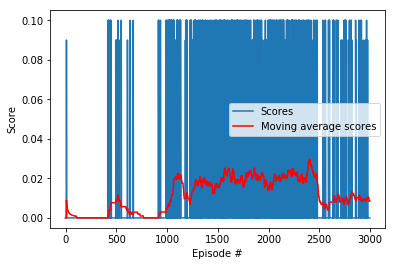

In [13]:
plot_scores(scores)

In [10]:
agent.actor_optimizer.param_groups[0]['lr']=agent.actor_optimizer.param_groups[0]['lr']/10
agent.critic_optimizer.param_groups[0]['lr']=agent.critic_optimizer.param_groups[0]['lr']/10

In [14]:
scores = ddpg()

	Steps:  9
Episode 1	Average Score: 0.00	Score: 0.000	Steps:  13
Episode 2	Average Score: 0.00	Score: 0.000

KeyboardInterrupt: 

In [ ]:
plot_scores(scores)

# Test

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment   

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

In [ ]:
agent = Agents(state_size=state_size, action_size=action_size,
               num_agents = num_agents, random_seed=0)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [ ]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
agent.reset() 
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (max over agents) this episode: {}'.format(np.max(scores)))

In [ ]:
env.close()